# Medical Abstract Classification with two approaches

In this notebook, we will explore a multiclass text-classification problem using two different approaches. First, a more traditional statistical approach, and later, a more experimental approach using Large Language Models in a zero-shot and few-shot setting.

Let's start by importing some basic modules we will be using, and then load in the data which will be used for the project.

In [1]:
%matplotlib inline

In [12]:
import pandas as pd
import numpy as np

import sklearn

import matplotlib as plt
import seaborn as sns

## Data

The data used in this notebook contains about 14k Medical Abstracts describing 5 different patient conditions. The data was compiled by Schopf et al. in conjunction with the paper "Evaluating Unsupervised Text Classification: Zero-Shot and Similarity-Based Approaches". The dataset can be found in full here: https://github.com/sebischair/Medical-Abstracts-TC-Corpus.

As I will later be using the OpenAI API (which is not free), I have choosen to remove 50% of the test data. While this might impact the results, this will save both time and compute when doing classification using the LLM.

Now, let's load in the data, and have a look at some examples.

In [4]:
train = pd.read_csv("../Medical-Abstracts-TC-Corpus/medical_tc_train.csv")
test = pd.read_csv("../Medical-Abstracts-TC-Corpus/medical_tc_test.csv")
labels = pd.read_csv("../Medical-Abstracts-TC-Corpus/medical_tc_labels.csv")

In [5]:
from sklearn.model_selection import train_test_split

# Remove 50% of test data. (Using train_test_split and stratify from sklearn here ensures that we maintain the class imbalance.)
test_medical_abstract, _, test_condition_label, _ = (
    train_test_split(
        test["medical_abstract"], 
        test["condition_label"], 
        train_size=0.5, 
        stratify=test["condition_label"], 
        random_state=42
    )
)

test = pd.DataFrame({"medical_abstract": test_medical_abstract, "condition_label": test_condition_label}).reset_index(drop=True)

In [6]:
train.head()

,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


In [7]:
for i in range(3):
    print("Medical abstract:", train.medical_abstract.iloc[i])
    print("=======")
    label = train.condition_label.iloc[i]
    label_name = labels.condition_name.iloc[label-1]
    print("Condition:", label_name)
    print("=======")

Medical abstract: Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interven

The Data also comes with descriptive labels for each condition. Let's take a look at all the labels, and do some pre processing so that we get the more descriptive labels in the train and test sets as well.

In [8]:
labels

,condition_label,condition_name
0,1,neoplasms
1,2,digestive system diseases
2,3,nervous system diseases
3,4,cardiovascular diseases
4,5,general pathological conditions


In [9]:
# Merge with labels DF
train = (
    train
    .merge(labels, how="left", on="condition_label")
    .drop(columns="condition_label")
    .rename(columns={"condition_name": "condition_label"})
)
test = (
    test
    .merge(labels, how="left", on="condition_label")
    .drop(columns="condition_label")
    .rename(columns={"condition_name": "condition_label"})
)

In [10]:
train.head()

,medical_abstract,condition_label
0,Tissue changes around loose prostheses. A cani...,general pathological conditions
1,Neuropeptide Y and neuron-specific enolase lev...,neoplasms
2,"Sexually transmitted diseases of the colon, re...",digestive system diseases
3,Lipolytic factors associated with murine and h...,neoplasms
4,Does carotid restenosis predict an increased r...,nervous system diseases


That looks better! Let's know get a better understanding of the structure of the data.

AttributeError: module 'matplotlib' has no attribute 'ylabel'

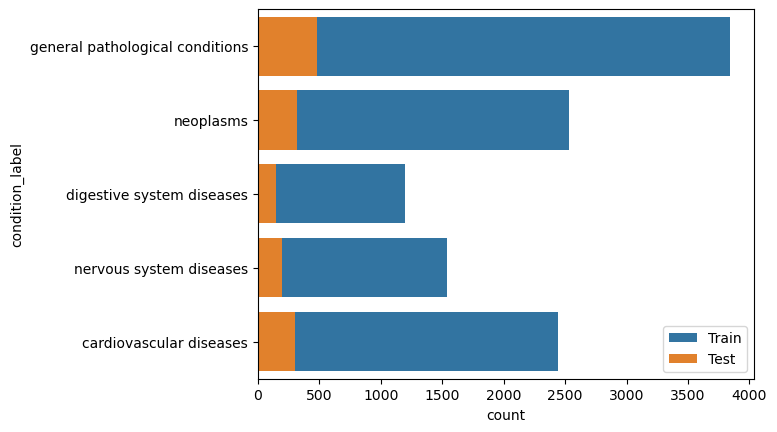

In [13]:
sns.countplot(data=train, y='condition_label', orient="h", label="Train")
sns.countplot(data=test, y='condition_label', orient="h", label="Test")

plt.ylabel("Condition Label")
plt.xlabel("Count")
plt.title("Nr of examples in each class")

plt.legend()

plt.show()

The plot shows that the data is quite imbalanced between the classes. This could pose a problem for statistical methods for classification, which often performs better across the classes if the training data is balanced. I will later adress this by undersampling to the minority class. We will also explore the use of LLMs in a zero-shot and few-shot setting for the classifcation, where the imbalance matters less. 

Let's first however to some more visualization to get a better understanding of each class.

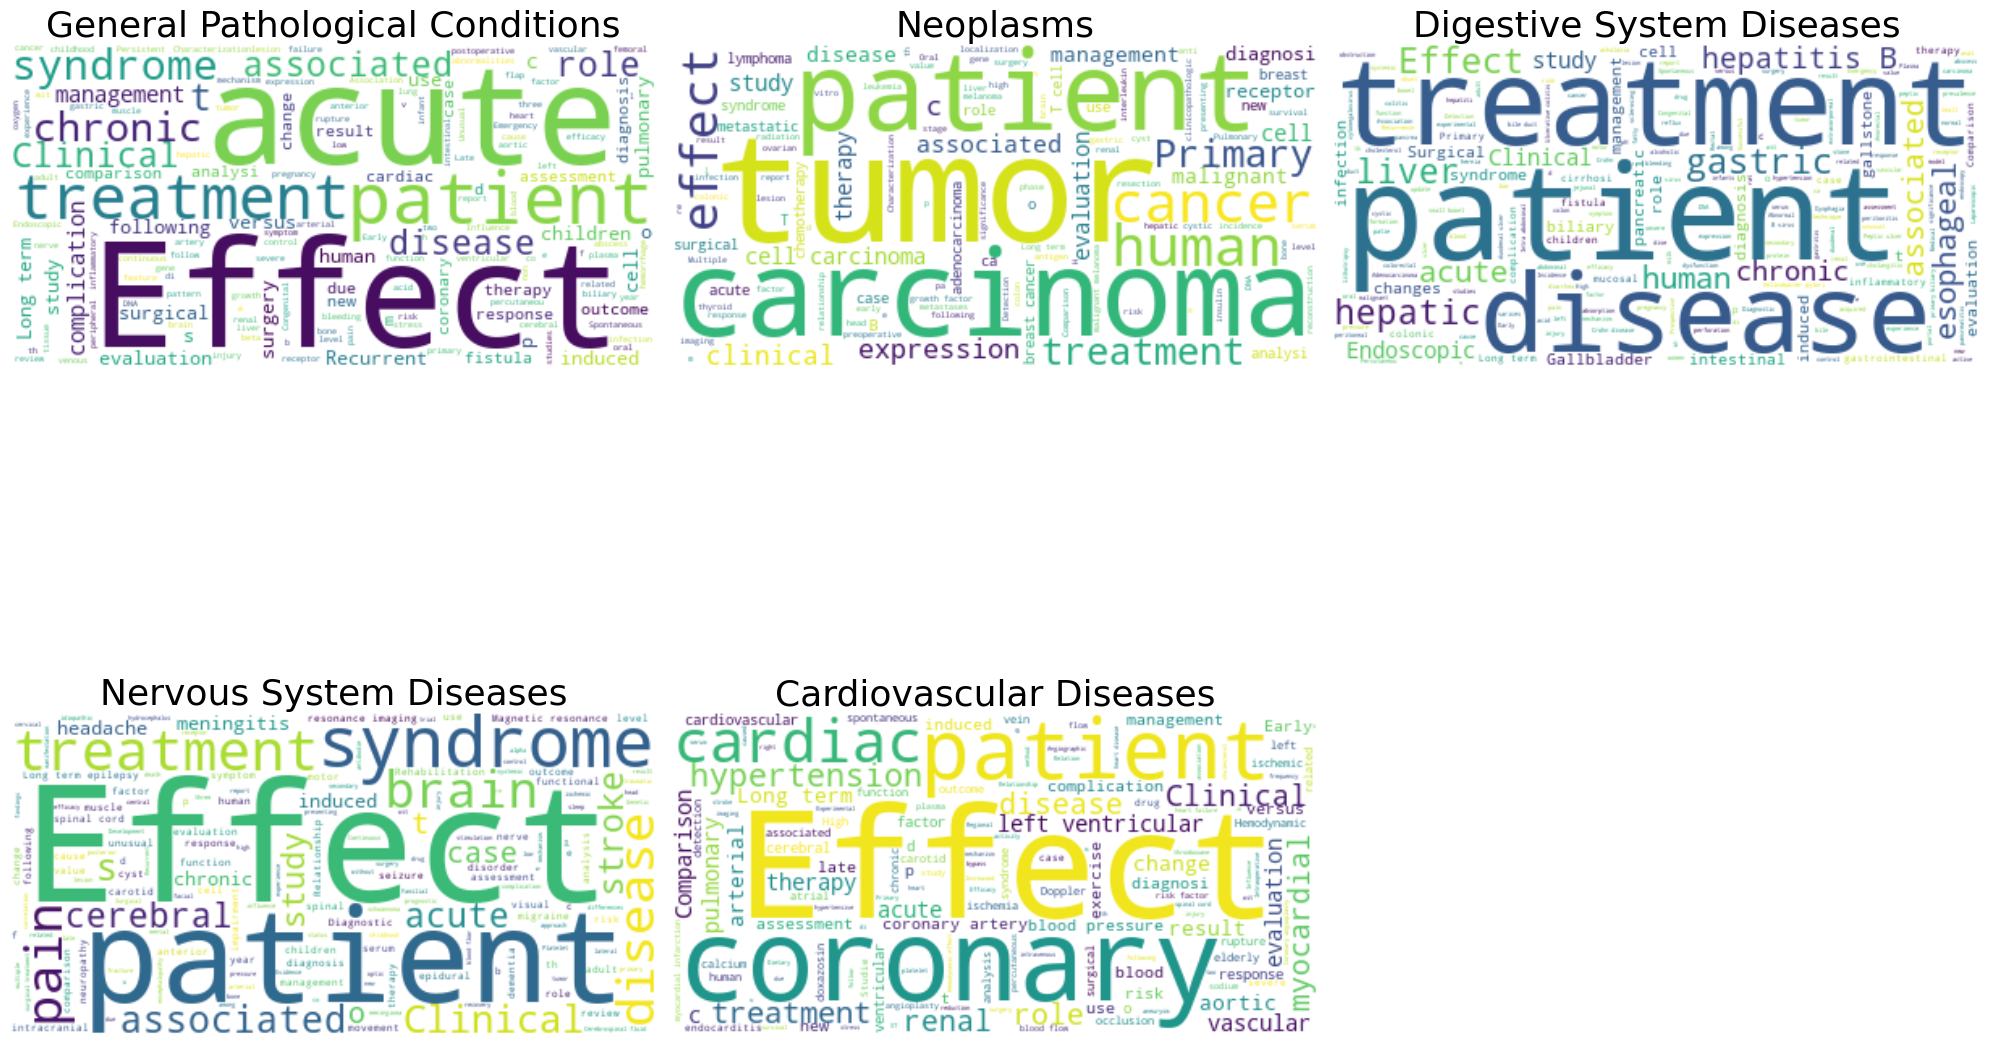

In [11]:
# Wordclouds
from wordcloud import WordCloud

general = train.medical_abstract.where(train.condition_label == "general pathological conditions").dropna()
neoplasms = train.medical_abstract.where(train.condition_label == "neoplasms").dropna()
digestive = train.medical_abstract.where(train.condition_label == "digestive system diseases").dropna()
nervous = train.medical_abstract.where(train.condition_label == "nervous system diseases").dropna()
cardiovascular = train.medical_abstract.where(train.condition_label == "cardiovascular diseases").dropna()

wordcloud1 = WordCloud(background_color='white').generate(general.to_string())
wordcloud2 = WordCloud(background_color='white').generate(neoplasms.to_string())
wordcloud3 = WordCloud(background_color='white').generate(digestive.to_string())
wordcloud4 = WordCloud(background_color='white').generate(nervous.to_string())
wordcloud5 = WordCloud(background_color='white').generate(cardiovascular.to_string())

plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)  
plt.imshow(wordcloud1, interpolation="bilinear")
plt.title("General Pathological Conditions", fontsize=26)
plt.axis("off")

plt.subplot(2, 3, 2)  
plt.imshow(wordcloud2, interpolation="bilinear")
plt.title("Neoplasms", fontsize=26)
plt.axis("off")

plt.subplot(2, 3, 3) 
plt.imshow(wordcloud3, interpolation="bilinear")
plt.title("Digestive System Diseases", fontsize=26)
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(wordcloud4, interpolation="bilinear")
plt.title("Nervous System Diseases", fontsize=26)
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(wordcloud5, interpolation="bilinear")
plt.title("Cardiovascular Diseases", fontsize=26)
plt.axis("off")

plt.tight_layout()
plt.show()

Here we can see some quite clear trends. For example, general pathological conditions contain words like "chronic" and also "acute" (however, also found in other categories but less frequently). Neoplasms include the words "tumor", "cancer", and "carcinoma". Digestive System Diseases include "gastric" and "hepatic", and Cardiovascular Diseases include "cardiac". many of these are of course not surprising.

We can see in the different word clouds that some words are quite common across all the categories (such as "patient", "effect" and "treatment", which is not surprising). For this reason, it might be a good idea to remove some common stop-words. For the statistical approaches, we will experiment with this. Later, when we will be dealing with  dealing with LLMs, this might however hurt the context, thus hurting the model's understanding. There is also a high chance that the contextual understanding of the model is complex enough to understand the important words already, rendering stop-word removal unnecessary.

Now let's tackle the imbalance, and then move on to the statistical approach.

In [12]:
from sklearn.utils import shuffle

# Undersampling

# Check which party has the least amount of speeches in the data set. This is the "quota" for each class.
quota = np.min(train['condition_label'].value_counts())

# Unique parties
conditions = train['condition_label'].unique()

# Randomly fill each partys "quota" with randomly sampled speeches. This will yield a list
# of panda dataframes which we will have to concat and shuffle. random_state=1 for reproducibility.
train_us = [train.get(train['condition_label'] == condition).sample(n=quota, random_state=1) for condition in conditions]

# Concat and shuffle the data
train_us = shuffle(pd.concat(train_us))

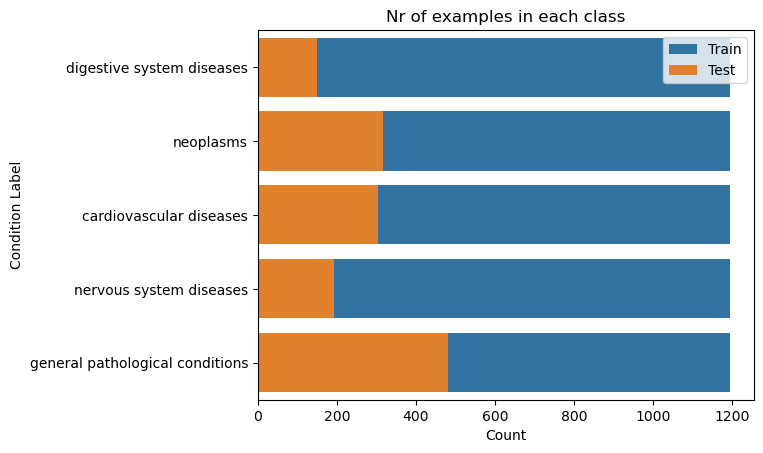

In [13]:
sns.countplot(data=train_us, y='condition_label', orient="h", label="Train")
sns.countplot(data=test, y='condition_label', orient="h", label="Test")

plt.ylabel("Condition Label")
plt.xlabel("Count")
plt.title("Nr of examples in each class")

plt.legend()

plt.show()

# Statistical Approach

As a baseline, I will implement a couple of different statistical methods for multiclass text classification. This will give us an basic understanding of the capabilities of statistical approaches to this task.

In [14]:
# Baseline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report

nb_pipe = make_pipeline(CountVectorizer(), MultinomialNB())
svm_pipe = make_pipeline(CountVectorizer(), SVC(kernel='linear'))
rf_pipe = make_pipeline(CountVectorizer(), RandomForestClassifier())
gb_pipe = make_pipeline(CountVectorizer(), GradientBoostingClassifier())

nb_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])
svm_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])
rf_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])
gb_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])

nb_pred = nb_pipe.predict(test['medical_abstract'])
svm_pred = svm_pipe.predict(test['medical_abstract'])
rf_pred = rf_pipe.predict(test['medical_abstract'])
gb_pred = gb_pipe.predict(test['medical_abstract'])

true = test['condition_label']

# Save reports
nb_report = classification_report(true, nb_pred, output_dict=True)
svm_report = classification_report(true, svm_pred, output_dict=True)
rf_report = classification_report(true, rf_pred, output_dict=True)
gb_report = classification_report(true, gb_pred, output_dict=True)

# Save metrics
nb_metrics = pd.DataFrame([{"model": "Naive Bayes", "accuracy": nb_report["accuracy"], **nb_report["weighted avg"]}])
svm_metrics = pd.DataFrame([{"model": "SVM", "accuracy": svm_report["accuracy"], **svm_report["weighted avg"]}])
rf_metrics = pd.DataFrame([{"model": "Random Forest", "accuracy": rf_report["accuracy"], **rf_report["weighted avg"]}])
gb_metrics = pd.DataFrame([{"model": "Gradient Boosting", "accuracy": gb_report["accuracy"], **gb_report["weighted avg"]}])

metrics = pd.concat([nb_metrics, svm_metrics, rf_metrics, gb_metrics], ignore_index=True).drop(columns=["support"])

print("Multinomial NB Classifier:")
print(classification_report(true, nb_pred))
print("=============================")
print("Support Vector Machines Classifier:")
print(classification_report(true, svm_pred))
print("=============================")
print("Random Forest Classifier:")
print(classification_report(true, rf_pred))
print("=============================")
print("Gradient Boosting Classifier:")
print(classification_report(true, gb_pred))

Multinomial NB Classifier:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.63      0.75      0.68       305
      digestive system diseases       0.40      0.73      0.52       150
general pathological conditions       0.53      0.20      0.29       481
                      neoplasms       0.66      0.74      0.70       316
        nervous system diseases       0.52      0.72      0.61       192

                       accuracy                           0.56      1444
                      macro avg       0.55      0.63      0.56      1444
                   weighted avg       0.56      0.56      0.53      1444

Support Vector Machines Classifier:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.58      0.60      0.59       305
      digestive system diseases       0.36      0.61      0.45       150
general pathological conditions       0.41      0.26     

In [15]:
metrics.round(2)

,model,accuracy,precision,recall,f1-score
0,Naive Bayes,0.56,0.56,0.56,0.53
1,SVM,0.48,0.48,0.48,0.47
2,Random Forest,0.52,0.51,0.52,0.48
3,Gradient Boosting,0.59,0.59,0.59,0.58


As we can see, the general accuracy of the statistical approaches is around 50 to 59%, where the Gradient Boosting classifier has the overall best accuracy. The different models also seems to struggle a bit differently with different classes, where some are easier to classify than others.

Let's do some visualizations of the results to better show them at a glance.

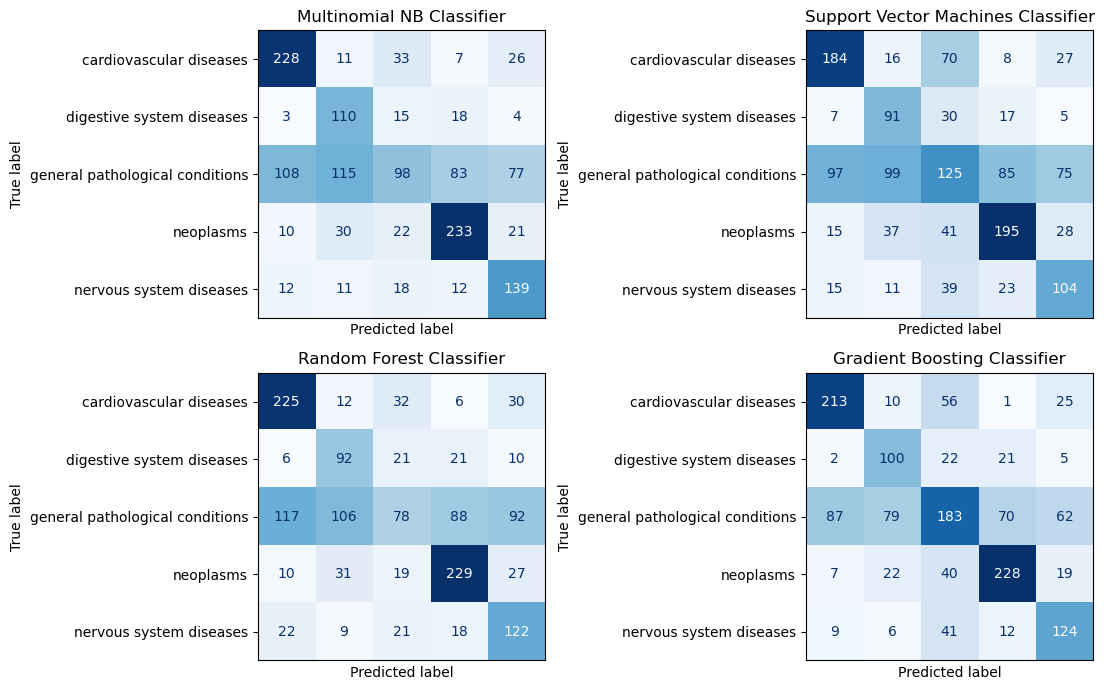

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors as mcolors

classifiers = [
    ("Multinomial NB Classifier", nb_pred),
    ("Support Vector Machines Classifier", svm_pred),
    ("Random Forest Classifier", rf_pred),
    ("Gradient Boosting Classifier", gb_pred)
]

# Plot confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
for (name, preds), ax in zip(classifiers, axes.flatten()):
    cm = confusion_matrix(true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_pipe.classes_)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_xticks([])
    ax.title.set_text(name)
plt.tight_layout()
plt.show()

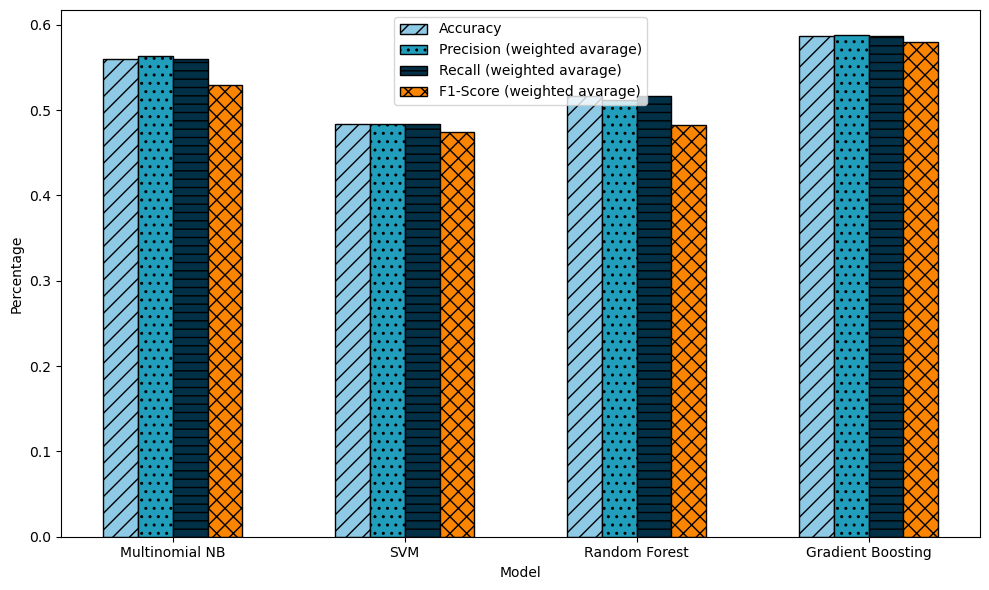

In [24]:
# Plot Bar plot
bar_width = 0.15

models = ["Multinomial NB", "SVM", "Random Forest", "Gradient Boosting"]

r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

hatches = ['//', '..', '--', 'xx']
colors = ['#8ecae6', '#219ebc', '#023047', '#fb8500']

# Make the plot
plt.figure(figsize=(10,6))
plt.bar(r1, metrics['accuracy'], hatch=hatches[0], color=colors[0], edgecolor='black', width=bar_width, label='Accuracy')
plt.bar(r2, metrics['precision'], hatch=hatches[1], color=colors[1], edgecolor='black', width=bar_width, label='Precision (weighted avarage)')
plt.bar(r3, metrics['recall'], hatch=hatches[2], color=colors[2], edgecolor='black', width=bar_width, label='Recall (weighted avarage)')
plt.bar(r4, metrics['f1-score'], hatch=hatches[3], color=colors[3], edgecolor='black', width=bar_width, label='F1-Score (weighted avarage)')

plt.xlabel('Model')
plt.ylabel('Percentage')
plt.xticks([r + 1.5*bar_width for r in range(len(models))], models)

plt.legend()
plt.tight_layout()
plt.show()

Let's also try to tackle the stop-word problem and see if removing them will improve the results.

For the stop words, I'll be using the nltk package as well as clinical stopwords found here: https://github.com/salgadev/medical-nlp

In [27]:
import nltk
from nltk.corpus import stopwords

# Stop words
file = "../clinical-stopwords.txt" # clinical stopwords from github: 
with open(file, "r") as f:
    clinical_stopwords = [line.strip() for line in f.readlines() if line.strip().isalpha()]

clinical_stopwords = clinical_stopwords[1:] # remove first entry since this line is not a stop word. 
additional_words = ["patient", "effect", "Effect", "treatment"] # Common words, which in this context hold little meaning.

# combine clinical, additional and nltk english stopwords.
stop_words = list(set(stopwords.words('english')).union(set(clinical_stopwords)).union(additional_words)) 

In [28]:
nb_pipe = make_pipeline(CountVectorizer(stop_words=stop_words), MultinomialNB())
svm_pipe = make_pipeline(CountVectorizer(stop_words=stop_words), SVC(kernel='linear'))
rf_pipe = make_pipeline(CountVectorizer(stop_words=stop_words), RandomForestClassifier())
gb_pipe = make_pipeline(CountVectorizer(stop_words=stop_words), GradientBoostingClassifier())

nb_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])
svm_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])
rf_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])
gb_pipe.fit(train_us['medical_abstract'], train_us['condition_label'])

nb_pred = nb_pipe.predict(test['medical_abstract'])
svm_pred = svm_pipe.predict(test['medical_abstract'])
rf_pred = rf_pipe.predict(test['medical_abstract'])
gb_pred = gb_pipe.predict(test['medical_abstract'])

true = test['condition_label']

# Save reports
nb_report = classification_report(true, nb_pred, output_dict=True)
svm_report = classification_report(true, svm_pred, output_dict=True)
rf_report = classification_report(true, rf_pred, output_dict=True)
gb_report = classification_report(true, gb_pred, output_dict=True)

# Save metrics
nb_metrics = pd.DataFrame([{"model": "Naive Bayes", "accuracy": nb_report["accuracy"], **nb_report["weighted avg"]}])
svm_metrics = pd.DataFrame([{"model": "SVM", "accuracy": svm_report["accuracy"], **svm_report["weighted avg"]}])
rf_metrics = pd.DataFrame([{"model": "Random Forest", "accuracy": rf_report["accuracy"], **rf_report["weighted avg"]}])
gb_metrics = pd.DataFrame([{"model": "Gradient Boosting", "accuracy": gb_report["accuracy"], **gb_report["weighted avg"]}])

metrics_processed = pd.concat([nb_metrics, svm_metrics, rf_metrics, gb_metrics], ignore_index=True).drop(columns=["support"])

print("Multinomial NB Classifier:")
print(classification_report(true, nb_pred))
print("=============================")
print("Support Vector Machines Classifier:")
print(classification_report(true, svm_pred))
print("=============================")
print("Random Forest Classifier:")
print(classification_report(true, rf_pred))
print("=============================")
print("Gradient Boosting Classifier:")
print(classification_report(true, gb_pred))

Multinomial NB Classifier:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.64      0.76      0.70       305
      digestive system diseases       0.40      0.74      0.52       150
general pathological conditions       0.55      0.21      0.30       481
                      neoplasms       0.66      0.74      0.70       316
        nervous system diseases       0.53      0.74      0.62       192

                       accuracy                           0.57      1444
                      macro avg       0.56      0.64      0.57      1444
                   weighted avg       0.57      0.57      0.54      1444

Support Vector Machines Classifier:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.61      0.62      0.61       305
      digestive system diseases       0.37      0.62      0.46       150
general pathological conditions       0.43      0.28     

In [29]:
metrics_processed.round(2)

,model,accuracy,precision,recall,f1-score
0,Naive Bayes,0.57,0.57,0.57,0.54
1,SVM,0.50,0.50,0.50,0.49
2,Random Forest,0.53,0.53,0.53,0.50
3,Gradient Boosting,0.60,0.60,0.60,0.59


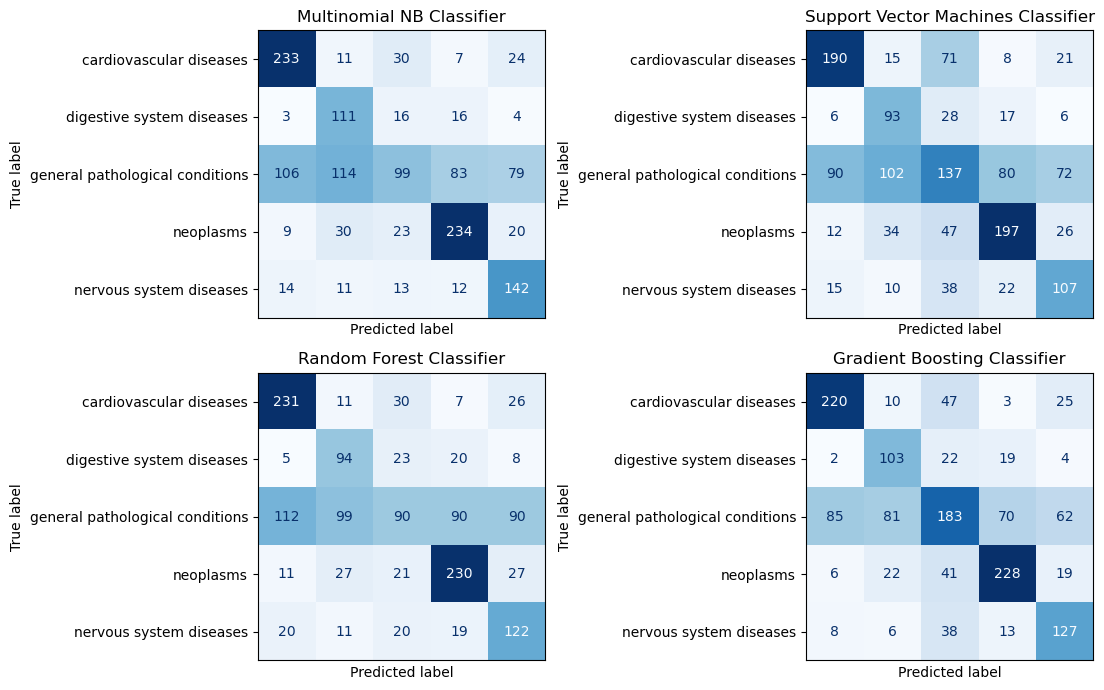

In [30]:
# Visualize

# Confusion matrices
classifiers = [
    ("Multinomial NB Classifier", nb_pred),
    ("Support Vector Machines Classifier", svm_pred),
    ("Random Forest Classifier", rf_pred),
    ("Gradient Boosting Classifier", gb_pred)
]

# Plot confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
for (name, preds), ax in zip(classifiers, axes.flatten()):
    cm = confusion_matrix(true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_pipe.classes_)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_xticks([])
    ax.title.set_text(name)
plt.tight_layout()
plt.show()

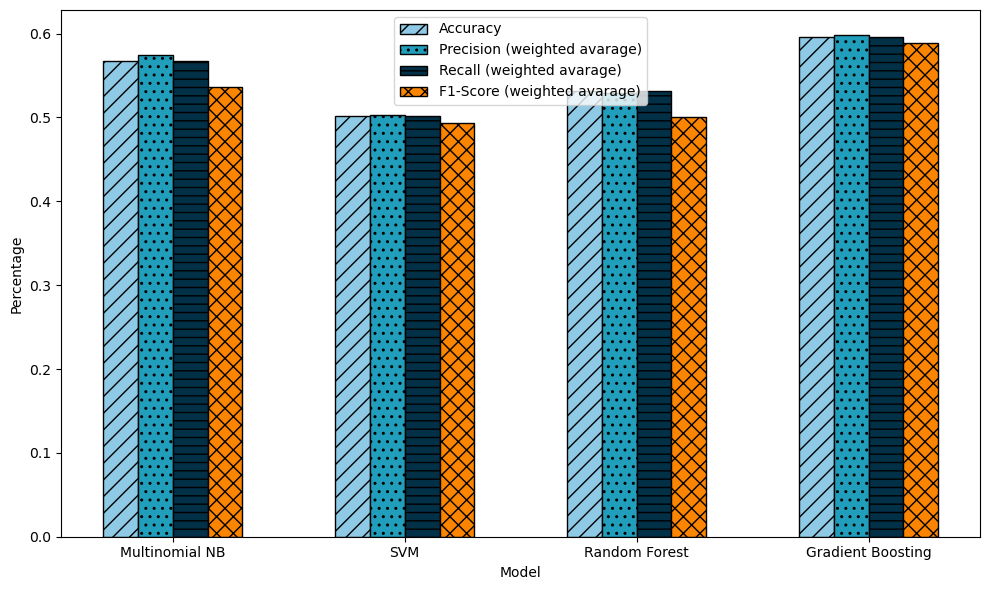

In [31]:
# Bar plot
# Make the plot
plt.figure(figsize=(10,6))
plt.bar(r1, metrics_processed['accuracy'], hatch=hatches[0], color=colors[0], edgecolor='black', width=bar_width, label='Accuracy')
plt.bar(r2, metrics_processed['precision'], hatch=hatches[1], color=colors[1], edgecolor='black', width=bar_width, label='Precision (weighted avarage)')
plt.bar(r3, metrics_processed['recall'], hatch=hatches[2], color=colors[2], edgecolor='black', width=bar_width, label='Recall (weighted avarage)')
plt.bar(r4, metrics_processed['f1-score'], hatch=hatches[3], color=colors[3], edgecolor='black', width=bar_width, label='F1-Score (weighted avarage)')

plt.xlabel('Model')
plt.ylabel('Percentage')
plt.xticks([r + 1.5*bar_width for r in range(len(models))], models)

plt.legend()
plt.tight_layout()
plt.show()

In [38]:
display(pd.concat([metrics.round(2), metrics_processed.round(2)], axis=1))

Compiled metrics. Results with stop words removed displayed to the right.


,model,accuracy,precision,recall,f1-score,model,accuracy,precision,recall,f1-score
0,Naive Bayes,0.56,0.56,0.56,0.53,Naive Bayes,0.57,0.57,0.57,0.54
1,SVM,0.48,0.48,0.48,0.47,SVM,0.50,0.50,0.50,0.49
2,Random Forest,0.52,0.51,0.52,0.48,Random Forest,0.53,0.53,0.53,0.50
3,Gradient Boosting,0.59,0.59,0.59,0.58,Gradient Boosting,0.60,0.60,0.60,0.59


Displaying the metrics side by side, we can see that the stop word-removal slightly improved all the models performance. To further improve, we could of course do more preprocessing, or tune the models hyperparameters. However, I think we know have a good understanding of the capabilities and limitations of the statistical approach, which will serve as a good baseline to compare with the more experimental approaches in the next part of the project.

## Zero-shot and Few Shot prompting

In [260]:
# Util function which only returns the generated answer, in case the model generates additonal tokens.
# If no condition is found, return None.
def find_pred_from_generated_answer(generated_answer: str) -> str:
    for condition in labels.condition_name.to_list():
        if condition in generated_answer:
            return condition
    return None

In [110]:
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

load_dotenv()
llm = ChatOpenAI(openai_api_key=os.getenv("OPEN_AI_KEY"), temperature=0)

# Load model using Ollama (run locally)
#llm = Ollama(model="phi", temperature=0)

# Act as a medical professional and classify the given medical abstract into one of these 5 categories:

# setup Prompt template
template = """Classify the given medical abstract into one of these 5 medical conditions:

1. neoplasms
2. digestive system diseases
3. nervous system diseases
4. cardiovascular diseases
5. general pathological conditions

Medical abstract: {abstract}

Condition: """
zero_shot_prompt = PromptTemplate(input_variables=["medical_abstract"],template=template)

In [111]:
# Create the zero shot chain
chain = zero_shot_prompt | llm 

In [118]:
zero_shot_preds = []
for example in test.medical_abstract.iloc[0:5]:
    res = chain.invoke({"abstract": example})
    zero_shot_preds.append(find_pred_from_generated_answer(res.content))
    #pred.append(find_pred_from_generated_answer(res))
zero_shot_preds_df = pd.DataFrame({"zero_shot_preds": zero_shot_preds})
zero_shot_preds_df

,zero_shot_preds
0,nervous system diseases
1,general pathological conditions
2,neoplasms
3,neoplasms
4,nervous system diseases


In [114]:
from langchain.prompts.few_shot import FewShotPromptTemplate

examples = [
    {
        "example": train.medical_abstract.iloc[0],
        "condition": train.condition_label.iloc[0],
    },
    {
        "example": train.medical_abstract.iloc[1],
        "condition": train.condition_label.iloc[1],
    },
    {
        "example": train.medical_abstract.iloc[2],
        "condition": train.condition_label.iloc[2],
    },
    {
        "example": train.medical_abstract.iloc[4],
        "condition": train.condition_label.iloc[4],
    },
    {
        "example": train.medical_abstract.iloc[7],
        "condition": train.condition_label.iloc[7],
    },
]

few_shot_template = """
Medical Abstract: {example}

Condition: {condition} 
"""

example_prompt = PromptTemplate(
    input_variables=["example", "condition"], template="Medical abstract: {example}\nCondition: {condition}"
)

prefix = """Classify the given medical abstract into one of these 5 medical conditions:

1. neoplasms
2. digestive system diseases
3. nervous system diseases
4. cardiovascular diseases
5. general pathological conditions

Base your answer on the following examples of medical abstracts and correctly labeled conditions:"""

few_shot_prompt = FewShotPromptTemplate(
    prefix=prefix,
    examples=examples,
    example_prompt=example_prompt,
    input_variables=["input"],
    suffix="Medical abstract: {abstract}\nCondition: ",
)

In [115]:
# Create the few shot chain
chain = few_shot_prompt | llm 

In [116]:
few_shot_preds = []
for example in test.medical_abstract.iloc[0:5]:
    res = chain.invoke({"abstract": example})
    few_shot_preds.append(find_pred_from_generated_answer(res.content))
few_shot_preds_df = pd.DataFrame({"zero_shot_preds": few_shot_preds})
few_shot_preds_df

content='nervous system diseases' response_metadata={'finish_reason': 'stop', 'logprobs': None}
content='nervous system diseases' response_metadata={'finish_reason': 'stop', 'logprobs': None}
content='neoplasms' response_metadata={'finish_reason': 'stop', 'logprobs': None}
content='neoplasms' response_metadata={'finish_reason': 'stop', 'logprobs': None}
content='nervous system diseases' response_metadata={'finish_reason': 'stop', 'logprobs': None}
['nervous system diseases', 'nervous system diseases', 'neoplasms', 'neoplasms', 'nervous system diseases']
